In [5]:
from PIL import Image
import requests
import tensorflow as tf
import pandas as pd

# https://huggingface.co/openai/clip-vit-large-patch14
from transformers import CLIPProcessor, TFCLIPModel

model = TFCLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
2023-07-03 08:55:18.491205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-03 08:55:18.491448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-03 08:55:18.509038: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-03 08:55:18.509278: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returnin

In [6]:
from functools import reduce

param_per_var = pd.DataFrame(
    [
        (
            'text' if 'text' in w.name else 'image', 
            reduce(int.__mul__, w.shape, 1)
        ) 
        for w in model.weights
    ],
    columns=['type', 'count']
)

display('Parameter count (in millions) per encoder')
param_per_var.groupby('type').sum('count') / 1e6

'Parameter count (in millions) per encoder'

,count
type,
image,303.966209
text,123.650304


In [7]:
urls = {
    'cat': "http://farm4.staticflickr.com/3062/2896957511_23def76e54_z.jpg",
    'zebra': "http://farm1.staticflickr.com/64/163712426_611deaebe0_z.jpg",
    'airplane': "https://s3.us-east-1.amazonaws.com/images.cocodataset.org/train2017/000000521402.jpg",
    'person': "https://s3.us-east-1.amazonaws.com/images.cocodataset.org/train2017/000000349663.jpg"
}

images = {
    t: Image.open(requests.get(url, stream=True).raw)
    for t, url in urls.items()
}

'cat'

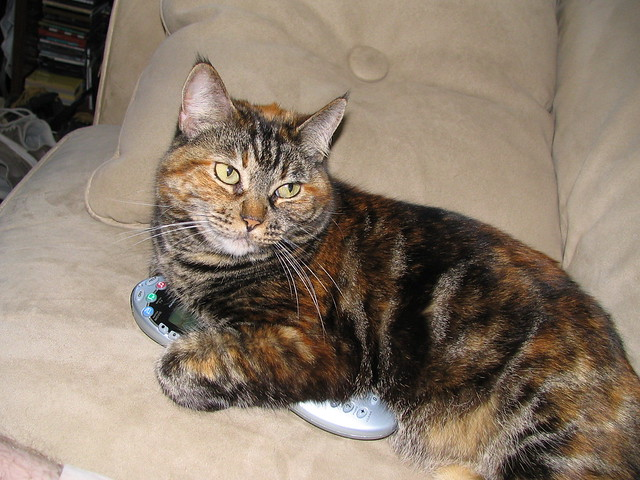

'zebra'

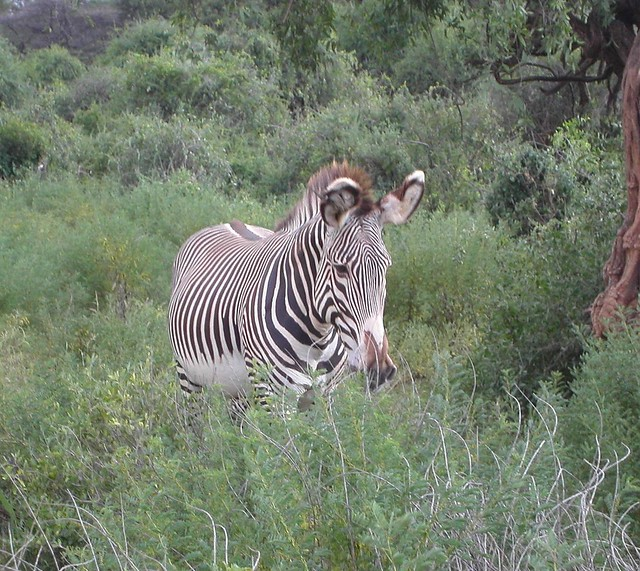

'airplane'

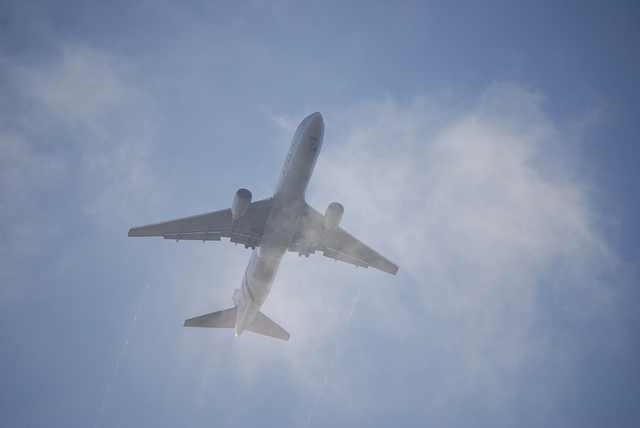

'person'

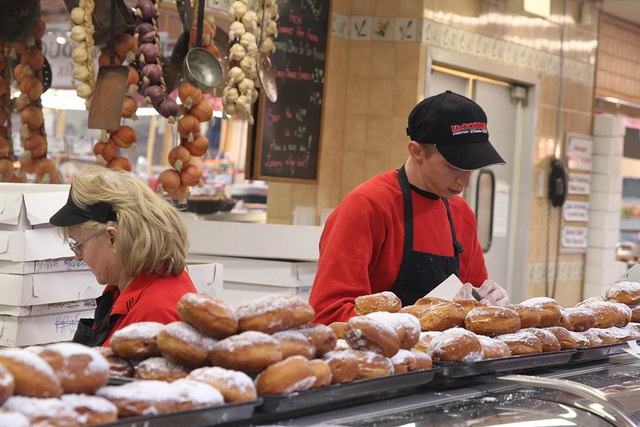

In [8]:
import matplotlib.pyplot as plt
for tag, image in images.items():
    display(tag)
    display(image)

### Task: Image-Text Similarity

In [9]:
captions = [
    "a photo of cat", 
    "a photo of zebra",
    "a photo of ocean",
    "a photo of person",
]

inputs = processor(
    text=captions, 
    images=list(images.values()), 
    return_tensors="tf", 
    padding=True
)

In [10]:
outputs = model(**inputs)

In [11]:
# this is the image-text similarity score
def display_scores(logits: tf.Tensor, captions: list[str]):
    probs = tf.nn.softmax(logits).numpy()
    df = pd.DataFrame(probs)
    df.columns = captions
    df.index = urls.keys()
    df = df.round(2)

    display(
        df.style
        .background_gradient(cmap ='RdYlGn', axis='columns')
        .format(precision=2)
    )
    
display_scores(outputs.logits_per_image, captions)

,a photo of cat,a photo of zebra,a photo of ocean,a photo of person
cat,0.99,0.00,0.00,0.00
zebra,0.00,1.00,0.00,0.00
airplane,0.08,0.24,0.38,0.29
person,0.06,0.05,0.04,0.85


### Task: Image Classification for Person / Not Person

In [12]:
pnp_captions = [
    "a person",
    "object or animal",
]

inputs = processor(
    text=pnp_captions, 
    images=list(images.values()), 
    return_tensors="tf", 
    padding=True
)

outputs = model(**inputs)

In [13]:
display_scores(outputs.logits_per_image, pnp_captions)

,a person,object or animal
cat,0.02,0.98
zebra,0.01,0.99
airplane,0.24,0.76
person,0.66,0.34


In [14]:
import numpy as np
import zipfile
import PIL.Image


def load_images(folder: str) -> np.ndarray:
    images = []
    with zipfile.ZipFile('../m02_cnn/pnp_dataset.zip') as z:
        targets = sorted(p for p in z.namelist() if p.startswith(folder))
        for target in targets:
            with z.open(target) as f:
                images.append(np.array(PIL.Image.open(f)))
            
    return np.array(images)

In [15]:
train_x = load_images('pnp_dataset/train_x')
with zipfile.ZipFile('../m02_cnn/pnp_dataset.zip') as z:
    with z.open('pnp_dataset/train_y.npy') as f:
        train_y = np.load(f)

In [16]:
def infer_similarity(
    images: np.ndarray, 
    captions: list[str], 
    batch_size: int = 100
) -> np.ndarray:

    # reorder dimensions: BHWC -> B[CHW]
    images = np.moveaxis(images, [3], [1])
    images = list(images)

    y_logit = []

    for i in range(0, len(images), batch_size):
        inputs = processor(
            text=captions, 
            images=images[i:i+batch_size], 
            return_tensors="tf", 
            padding=True
        )
        outputs = model(**inputs)
        y_logit.append(outputs.logits_per_image)
        
    y_logit = tf.concat([t.numpy() for t in y_logit], axis=0)
    
    if y_logit.shape[1] > 1:
        y_probs = tf.nn.softmax(y_logit)
    else:
        y_probs = tf.math.sigmoid(y_logit)
        
    return y_probs.numpy()

In [17]:
sample_size = 1000
sample_x = train_x[:sample_size]
sample_y = train_y[:sample_size]

sample_y_hat_probs = infer_similarity(sample_x, pnp_captions)
sample_y_hat_labels = (sample_y_hat_probs[:, 0] > 0.5)

In [18]:
accuracy = (sample_y == sample_y_hat_labels).mean().round(2)
accuracy

0.68

### Task: Image Search by Text Query

In [19]:
query_probs = infer_similarity(
    images=sample_x, 
    captions=[
        'person riding a horse',
        ''
    ]
)

In [20]:
query_probs.shape

(1000, 2)

In [21]:
# get indices of top-5 highest probability images
top_k = 5
idx_prob_pairs = enumerate(query_probs[:, 0].tolist())
top_idxs = sorted(
    idx_prob_pairs, 
    key=lambda idx_score: -idx_score[1]
)[:top_k]

'similarity = 1.0'

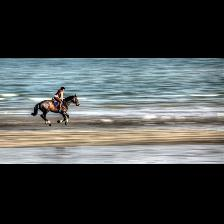

'similarity = 1.0'

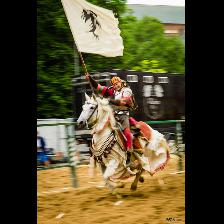

'similarity = 1.0'

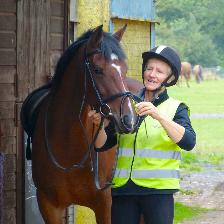

'similarity = 1.0'

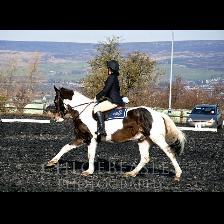

'similarity = 1.0'

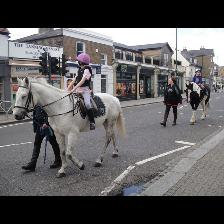

In [22]:
# display images
for idx, score in top_idxs:
    display(f'similarity = {round(score, 2)}')
    display(Image.fromarray(sample_x[idx]))